<a href="https://colab.research.google.com/github/Michael-Santoro/HMProductRecommendation/blob/main/SalesPrediction_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Prediction - Part 1
**Michael Santoro - michael.santoro@du.edu**</br>
With the discovery required to accomplish the image decompisition there was alot to be worked through. So the work will be split between multiple notebooks with the take-aways from the work from the previous notebook.
1. Part 1 - Data Cleaning, Model Selection, Feature Reduction
1. Part 2 - Transaction Analysis
# Introduction
This problem was initially introduced as a Kaggle competition. [source](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/overview)

The general idea being that images of articles can be simplified in terms of features using similar deep learning model architectures that are used for image classification. Then the simplified feature space can be used to cluster. These clusters then can be used to encode transactions into cluster sets. Once the cluster sets are put together, a recomendation can be made to a customer for another items that others are adding to their cart.

# Kaggle Download and Packages Install

In [1]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!kaggle config set path -v /content
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

import os
import zipfile

zip_ref = zipfile.ZipFile('/content/h-and-m-personalized-fashion-recommendations.zip', 'r')
zip_ref.extractall()
zip_ref.close()

#Hugging Face
!pip install transformers

#UMAP
!pip install umap-learn

usage: kaggle config set
       [-h]
       -n
       NAME
       -v
       VALUE
kaggle config set: error: the following arguments are required: -n/--name
100% 28.7G/28.7G [21:05<00:00, 28.0MB/s]
100% 28.7G/28.7G [21:05<00:00, 24.3MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=8282

# Imports

In [2]:
import os
import pandas as pd
import numpy as np

from PIL import Image

from transformers import AutoImageProcessor, ViTModel, ImageGPTModel, ViTMAEModel

import torch
from torch import nn
from torchsummary import summary
import copy
from collections import defaultdict

from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import seaborn as sns
import plotly.express as px
import umap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_dir = '/content/images'

# Preparation and Info from Part 1

## Available Images

In [3]:
tree = os.walk('/content/images')
images_available = []
for i in tree:
  # print(i)
  if i[0] != '/content/images':
    for j in i[-1]:
      images_available.append(j.split('.')[0])
len(images_available)

105100

## Model Preparation

In [4]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
model.to(device)
def getFeatureVecor_mean(art_num):
  im = Image.open(os.path.join(img_dir, art_num[:3], f'{art_num}.jpg'))
  inputs = image_processor(images=im, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = model(**inputs)
  arr = outputs['last_hidden_state'].cpu().detach().numpy()
  #arr dims => (1, 197, 768)
  return arr.mean(axis=1).reshape(768,)

# Transactions

In [5]:
transactions = pd.read_csv('/content/transactions_train.csv',nrows=10000,low_memory=False)
transactions.article_id = transactions.article_id.astype('str').str.zfill(10)
transactions = transactions[transactions.article_id.isin(images_available)]
col_map = {name:idx for idx,name in enumerate(transactions.columns)}
transactions.shape

(9917, 5)

In [6]:
art_to_vec = {i:getFeatureVecor_mean(i) for i in transactions.article_id.unique()}

In [7]:
X = np.array(transactions.article_id.map(art_to_vec).to_list())
X.shape


(9917, 768)

## UMAP
[link](https://umap-learn.readthedocs.io/en/latest/clustering.html)

In [8]:
_umap = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=3,
    random_state=42,
)
reduced = _umap.fit_transform(X)

In [9]:
df = pd.DataFrame(reduced,columns=['x','y','z'])

fig = px.scatter_3d(df, x="x", y="y", z="z")
fig.show()

# K-Means Clustering

In [10]:
d = defaultdict(list)
for n in list(range(25,501,25)):
  k_means = KMeans(n_clusters=n, max_iter=1000)
  k_means.fit(reduced)

  cluster_labels = k_means.labels_

  label=k_means.predict(reduced)
  d['num_clusters'].append(n)
  d['silhouette_scores'].append(silhouette_score(reduced, label))
  d['distortions'].append(sum(np.min(cdist(reduced, k_means.cluster_centers_,
                                        'euclidean'), axis=1)) / reduced.shape[0])

<AxesSubplot:xlabel='num_clusters'>

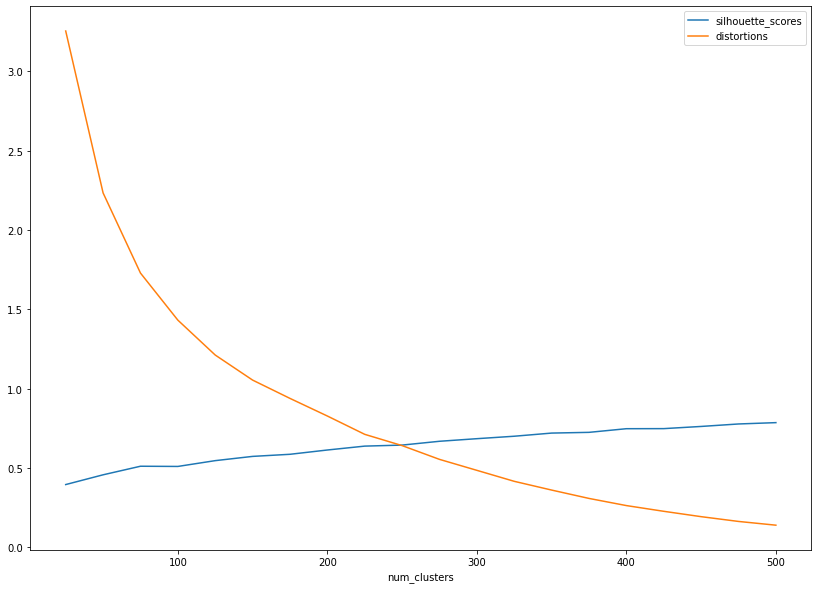

In [11]:
_df = pd.DataFrame(d)
_df.set_index('num_clusters',inplace=True)
_df.plot(figsize=(14,10))

In [13]:
_df.loc[200:300]

,silhouette_scores,distortions
num_clusters,,
200,0.613881,0.828029
225,0.638364,0.712578
250,0.644863,0.641589
275,0.668850,0.554845
300,0.685189,0.485755


In [15]:
k_means = KMeans(n_clusters=146, max_iter=1000)
k_means.fit(reduced)

df['cluster_id'] = k_means.predict(reduced)

fig = px.scatter_3d(df, x="x", y="y", z="z", color='cluster_id')
fig.show()

# Transaction Association

In [16]:
transactions['cluster_id'] = df['cluster_id'].values

col_map = {name:idx for idx,name in enumerate(transactions.columns)}

def mapTransactions(row):
  return {'transaction_id':f'{row[col_map["t_dat"]]}_{row[col_map["customer_id"]]}', f'{"cluster_id"}':f'{row[col_map["cluster_id"]]}'}

result = transactions.apply(mapTransactions, axis=1)
processed_transactions = pd.DataFrame(list(result.values))
processed_transactions

,transaction_id,cluster_id
0,2018-09-20_000058a12d5b43e67d225668fa1f8d618c1...,123
1,2018-09-20_000058a12d5b43e67d225668fa1f8d618c1...,0
2,2018-09-20_00007d2de826758b65a93dd24ce629ed668...,109
3,2018-09-20_00007d2de826758b65a93dd24ce629ed668...,9
4,2018-09-20_00007d2de826758b65a93dd24ce629ed668...,24
...,...,...
9912,2018-09-20_366b89e56112858fd747d2b8ec9519b8c78...,145
9913,2018-09-20_366d7effce9489934c3317a8e4e1828622d...,122
9914,2018-09-20_366d7effce9489934c3317a8e4e1828622d...,69
9915,2018-09-20_366d7effce9489934c3317a8e4e1828622d...,14


In [17]:
processed_transactions = processed_transactions.groupby('transaction_id').agg({'cluster_id':lambda x:list(x)})
data = [x[0] for x in processed_transactions.values.tolist()]

In [18]:
a = TransactionEncoder()
a_data = a.fit(data).transform(data)
trans_encoder = pd.DataFrame(a_data,columns=a.columns_)
trans_encoder

,0,1,10,100,101,102,103,104,105,106,...,90,91,92,93,94,95,96,97,98,99
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2940,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2941,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2942,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [21]:
#set a threshold value for the support value and calculate the support value.
ap_result = apriori(trans_encoder, min_support = 0.001, use_colnames = True) ## Probabilities Need to be very low and get more descriptive.
ap_result

,support,itemsets
0,0.048234,(0)
1,0.036685,(1)
2,0.046535,(10)
3,0.010190,(100)
4,0.023098,(101)
...,...,...
3107,0.001019,"(31, 115, 20, 79, 123)"
3108,0.001019,"(142, 21, 20, 122, 123)"
3109,0.001019,"(115, 20, 122, 1, 107, 123)"
3110,0.001019,"(115, 142, 21, 1, 107, 123)"


In [22]:
#Let's view our interpretation values using the Associan rule function.
df_ar = association_rules(ap_result, metric = "confidence", min_threshold = 0.001)
df_ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0),(1),0.048234,0.036685,0.002038,0.042254,1.151800,0.000269,1.005814
1,(1),(0),0.036685,0.048234,0.002038,0.055556,1.151800,0.000269,1.007753
2,(10),(0),0.046535,0.048234,0.003397,0.072993,1.513313,0.001152,1.026709
3,(0),(10),0.048234,0.046535,0.003397,0.070423,1.513313,0.001152,1.025697
4,(0),(100),0.048234,0.010190,0.002038,0.042254,4.146479,0.001547,1.033478
...,...,...,...,...,...,...,...,...,...
12023,(142),"(115, 21, 20, 122, 123)",0.026834,0.001019,0.001019,0.037975,37.265823,0.000992,1.038414
12024,(21),"(115, 142, 20, 122, 123)",0.028533,0.001019,0.001019,0.035714,35.047619,0.000990,1.035980
12025,(122),"(115, 142, 21, 20, 123)",0.026155,0.001019,0.001019,0.038961,38.233766,0.000992,1.039480
12026,(20),"(115, 142, 21, 122, 123)",0.039062,0.001019,0.001019,0.026087,25.600000,0.000979,1.025739


# New Transaction Review

In [23]:
new_trans = pd.read_csv('/content/transactions_train.csv',header=0,skiprows=range(1,10000),nrows=100,low_memory=False)
new_trans.article_id = transactions.article_id.astype('str').str.zfill(10)
new_trans = new_trans[new_trans.article_id.isin(images_available)]

In [24]:
art_to_vec = {i:getFeatureVecor_mean(i) for i in new_trans.article_id.unique()}

In [25]:
def mapTransactions(row):
  return {'transaction_id':f'{row[col_map["t_dat"]]}_{row[col_map["customer_id"]]}', f'{"article_id"}':f'{row[col_map["article_id"]]}'}

In [27]:
result = new_trans.apply(mapTransactions, axis=1)
processed_transactions = pd.DataFrame(list(result.values))
processed_transactions = processed_transactions.groupby('transaction_id').agg({'article_id':lambda x:list(x)})

In [28]:
processed_transactions

,article_id
transaction_id,
2018-09-20_366d7effce9489934c3317a8e4e1828622d51f30cee29cf3289edebd0a042807,[0663713001]
2018-09-20_366f8084581745ea281849d09dd9f5974c55432692353956d3e633294e7b10ff,"[0541518023, 0505221004, 0685687003, 068568700..."
2018-09-20_3670931e0fce92b56823b3fcbacbec354b5da07f3cba16a9770584a5293fb941,[0501820043]
2018-09-20_367c5863b64f384a70b7f944e12a05a0f309b2e9dbe83161fcc3e17be0fb7b20,[0501820043]
2018-09-20_3680b75cefe3e86dc6b1bc2096acb25ea1830c02dc17558e61e246ea0b7b41c5,"[0674681001, 0671505001]"
2018-09-20_3680e94361709c0d64118634e50f1035fffa8f045357db4d2cd41927b0522a43,"[0671505001, 0631848002]"
2018-09-20_3681587697523672d209b463688f0d95ad617ae16e7d851e3b045a8d7f709ecb,[0631848002]
2018-09-20_3681748607f3287d2c3a65e00bb5fb153de30e9becf158c99fde75e86f498cac,"[0631848002, 0631848002, 0680187001, 067682700..."
2018-09-20_368bf9b290d1342961ec84b7cd5c94d9ffdb9376c49232f51c318d03c16f2ac7,"[0680912006, 0692454002, 0692454002]"


In [29]:
ex_cart = processed_transactions.values[1][0]
ex_cart

['0541518023',
 '0505221004',
 '0685687003',
 '0685687004',
 '0685687001',
 '0505221001',
 '0688873012',
 '0501323011',
 '0598859003',
 '0688873020',
 '0688873011',
 '0531310002',
 '0529841001']

In [30]:
def showImagebyArt(art_num):
  im = Image.open(os.path.join(img_dir, art_num[:3], f'{art_num}.jpg'))
  display(im)

## Article 1

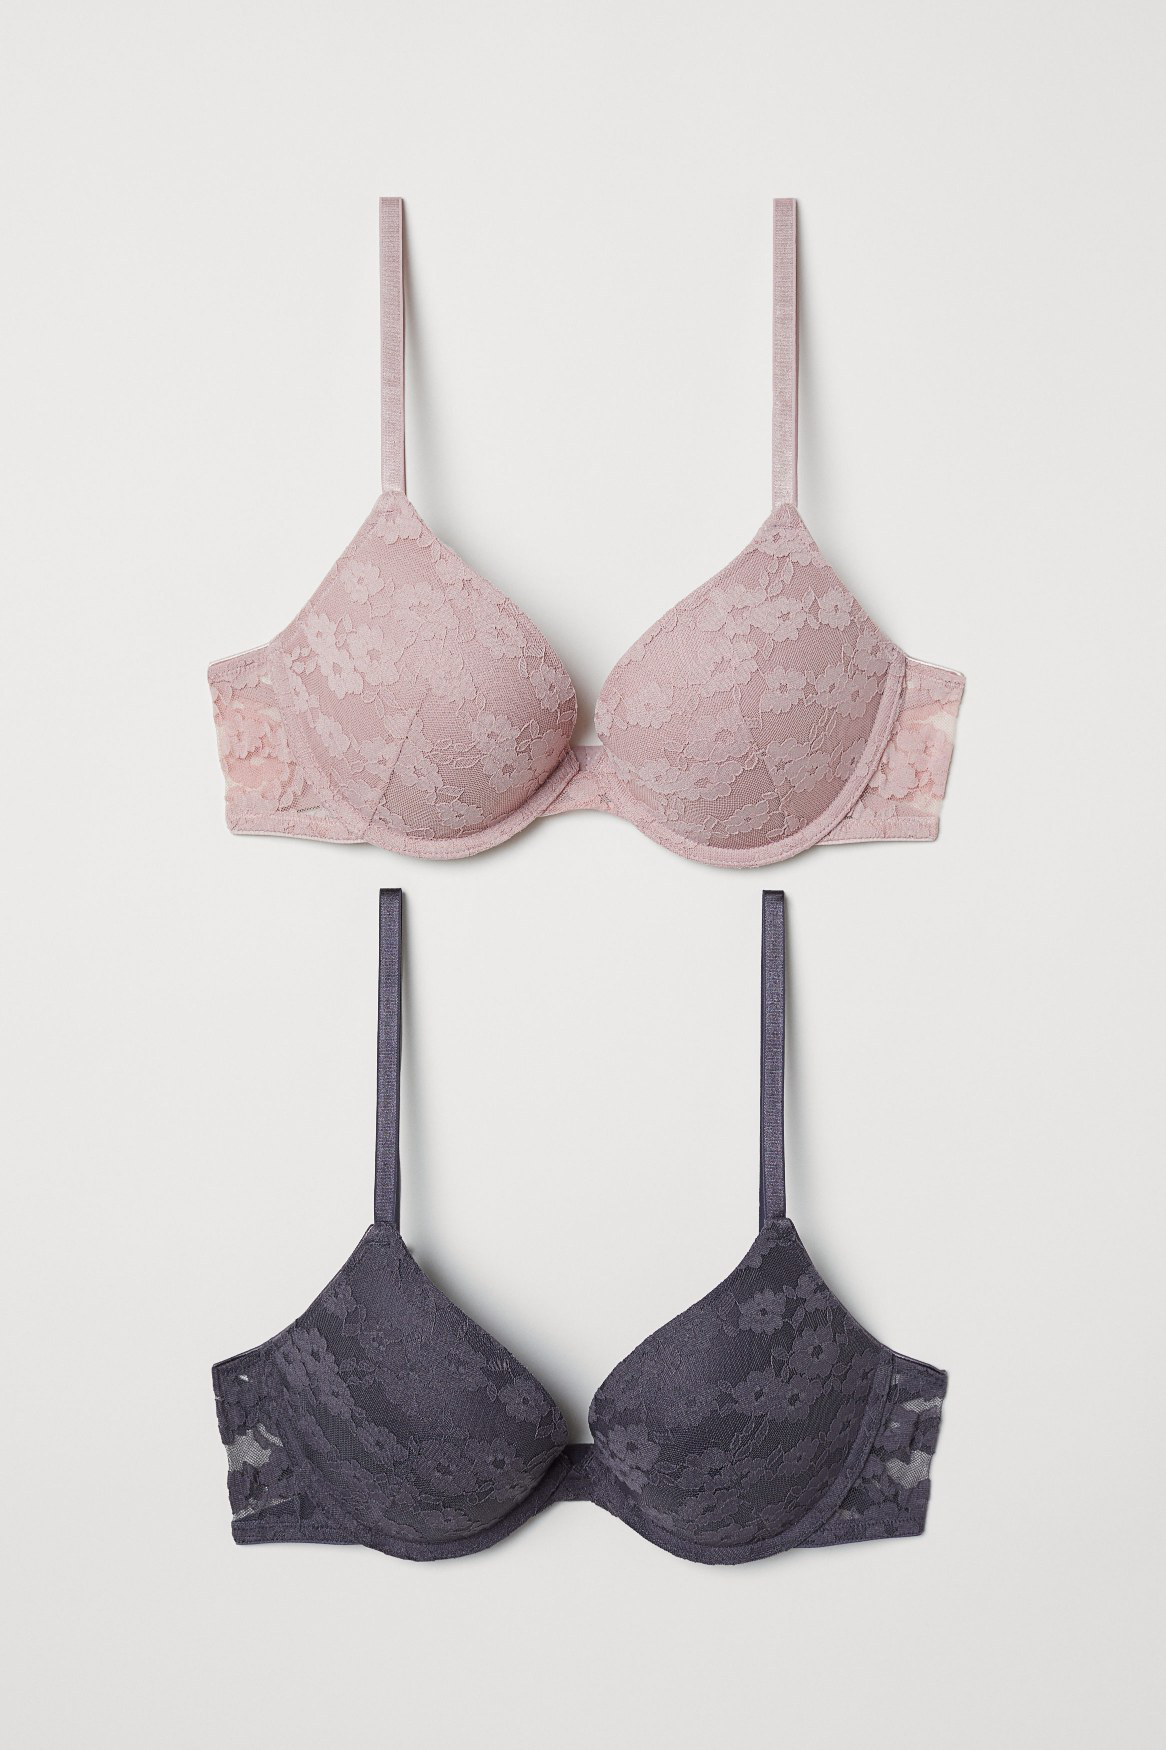

In [31]:
showImagebyArt(ex_cart[0])

In [19]:
X = np.array(new_trans.article_id.map(art_to_vec).to_list())
X.shape

(99, 768)

In [21]:
new_trans['cluster_id'] = k_means.predict(_umap.transform(X))

In [22]:
col_map = {name:idx for idx,name in enumerate(new_trans.columns)}

In [23]:
col_map

{'t_dat': 0,
 'customer_id': 1,
 'article_id': 2,
 'price': 3,
 'sales_channel_id': 4,
 'cluster_id': 5}

In [24]:
def mapTransactions(row):
  return {'transaction_id':f'{row[col_map["t_dat"]]}_{row[col_map["customer_id"]]}', f'{"cluster_id"}':f'{row[col_map["cluster_id"]]}'}

In [25]:
result = new_trans.apply(mapTransactions, axis=1)
processed_transactions = pd.DataFrame(list(result.values))

In [26]:
processed_transactions

,transaction_id,cluster_id
0,2018-09-20_366d7effce9489934c3317a8e4e1828622d...,4
1,2018-09-20_366f8084581745ea281849d09dd9f5974c5...,38
2,2018-09-20_366f8084581745ea281849d09dd9f5974c5...,21
3,2018-09-20_366f8084581745ea281849d09dd9f5974c5...,111
4,2018-09-20_366f8084581745ea281849d09dd9f5974c5...,5
...,...,...
94,2018-09-20_36d6361b9016c560727acd7dd7ef6de60ba...,66
95,2018-09-20_36d6361b9016c560727acd7dd7ef6de60ba...,81
96,2018-09-20_36d6361b9016c560727acd7dd7ef6de60ba...,124
97,2018-09-20_36d6361b9016c560727acd7dd7ef6de60ba...,100


In [27]:
processed_transactions = processed_transactions.groupby('transaction_id').agg({'cluster_id':lambda x:list(x)})

In [28]:
processed_transactions

,cluster_id
transaction_id,
2018-09-20_366d7effce9489934c3317a8e4e1828622d51f30cee29cf3289edebd0a042807,[4]
2018-09-20_366f8084581745ea281849d09dd9f5974c55432692353956d3e633294e7b10ff,"[38, 21, 111, 5, 59, 111, 64, 23, 71, 137, 144..."
2018-09-20_3670931e0fce92b56823b3fcbacbec354b5da07f3cba16a9770584a5293fb941,[121]
2018-09-20_367c5863b64f384a70b7f944e12a05a0f309b2e9dbe83161fcc3e17be0fb7b20,[121]
2018-09-20_3680b75cefe3e86dc6b1bc2096acb25ea1830c02dc17558e61e246ea0b7b41c5,"[4, 124]"
2018-09-20_3680e94361709c0d64118634e50f1035fffa8f045357db4d2cd41927b0522a43,"[124, 7]"
2018-09-20_3681587697523672d209b463688f0d95ad617ae16e7d851e3b045a8d7f709ecb,[7]
2018-09-20_3681748607f3287d2c3a65e00bb5fb153de30e9becf158c99fde75e86f498cac,"[7, 7, 139, 19, 19, 24, 24, 87]"
2018-09-20_368bf9b290d1342961ec84b7cd5c94d9ffdb9376c49232f51c318d03c16f2ac7,"[87, 114, 114]"


In [31]:
ex_cart = processed_transactions.values[1][0]

In [38]:
df_ar[df_ar.antecedents==frozenset(ex_cart[0])]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [34]:
ex_cart[0]

'38'

In [52]:
df_ar.antecedents[0]


frozenset({'38'})

In [50]:
temp = int(ex_cart[0])

In [51]:
frozenset(temp)

TypeError: ignored

In [47]:
type(int(ex_cart[0]))

int